In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


In [3]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
num_epochs = 5

In [4]:
# this is our input placeholder
input_img = Input(shape=(784,))
input_img

<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>

In [5]:
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded

<tf.Tensor 'dense_3/Relu:0' shape=(?, 32) dtype=float32>

In [6]:
# "decoded" is the lossy reconstruction of the input
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
decoded

<tf.Tensor 'dense_6/Sigmoid:0' shape=(?, 784) dtype=float32>

In [8]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total para

In [9]:
#Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [27]:
# as well as the decoder model:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer_last = autoencoder.layers[-1]
decoder_layer_2ndlast = autoencoder.layers[-2]
decoder_layer_3rdlast = autoencoder.layers[-3]
# create the decoder model
decoder = Model(encoded_input,
                decoder_layer_last(decoder_layer_2ndlast(decoder_layer_3rdlast(encoded_input))))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


In [28]:
# First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [29]:
(x_train, _), (x_test, _) = mnist.load_data(path = './mnist.npz')
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [30]:
#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [31]:
autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s - loss: 0.3497 - val_loss: 0.2640
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.2588 - val_loss: 0.2515
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.2444 - val_loss: 0.2382s
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.2324 - val_loss: 0.2246
Epoch 5/5
60000/60000 [==============================] - 5s - loss: 0.2207 - val_loss: 0.2124


In [35]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

(10000, 32)

In [36]:
# how sparse are the encodings
encoded_imgs.mean()

2.1184025

In [37]:
decoded_imgs = decoder.predict(encoded_imgs)

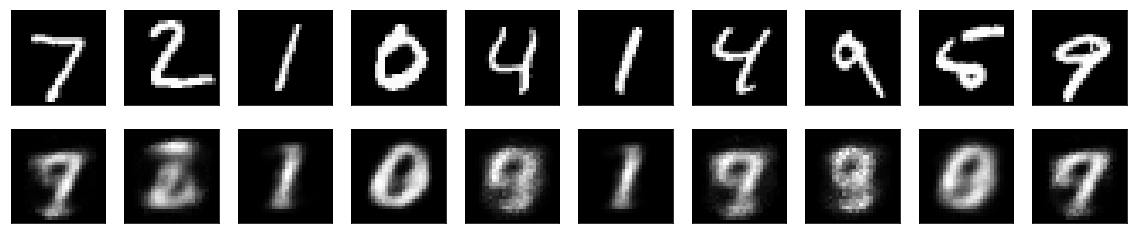

In [38]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()